In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import nibabel as nib
import glob
import os
from nilearn.plotting import plot_stat_map, view_img, plot_glass_brain
from nilearn.image import concat_imgs, smooth_img, mean_img, math_img, resample_to_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import non_parametric_inference

In [34]:
reg = 'valBundleSum_par'
l2_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level2/model3_reg-rt0'
l2_imgs = glob.glob(os.path.join(l2_path, '*/*/*%s*'%(reg)))

## How can l3 t values be larger than the largest t values in the individual l2 mean maps?

Is it because they are enhanced TFCE statistics instaed of raw T stats?

When I tried voxelwise setting `tfce=False` and checked the min and max values in `randomise_results.outputs.tstat_files` they were the same as the outputs using tfce.

Below are the min and max values along with their locations in each l2 image.

In [35]:
for img in l2_imgs:
    tmp = nib.load(img)
    tmp_data = tmp.get_fdata()
    print(round(np.min(tmp_data), 3), np.unravel_index(np.argmin(tmp_data, axis=None), tmp_data.shape), round(np.max(tmp_data), 3), np.unravel_index(np.argmax(tmp_data, axis=None), tmp_data.shape))
    

-4.645 (57, 73, 59) 4.611 (65, 69, 26)
-4.548 (68, 46, 33) 4.07 (53, 55, 43)
-4.133 (47, 23, 36) 4.827 (34, 34, 37)
-4.342 (43, 35, 68) 4.723 (47, 92, 51)
-3.99 (52, 53, 34) 4.111 (73, 50, 30)
-5.144 (40, 88, 43) 4.369 (55, 26, 30)
-4.954 (47, 15, 43) 4.453 (52, 59, 49)
-3.725 (37, 39, 52) 4.534 (19, 31, 46)
-3.943 (42, 82, 55) 4.814 (64, 46, 25)
-4.31 (55, 92, 49) 4.676 (50, 101, 51)
-4.91 (55, 24, 41) 3.955 (58, 60, 32)
-3.396 (35, 29, 10) 4.142 (48, 54, 49)
-4.147 (15, 39, 52) 4.565 (49, 20, 21)
-4.085 (58, 49, 53) 4.781 (62, 55, 41)
-4.91 (31, 69, 67) 5.049 (45, 60, 40)
-4.104 (52, 85, 71) 4.595 (34, 74, 31)
-4.67 (53, 78, 57) 4.493 (49, 75, 46)
-4.112 (41, 54, 80) 4.443 (76, 48, 61)
-3.667 (27, 40, 30) 4.289 (58, 20, 42)
-3.566 (45, 74, 48) 4.587 (63, 75, 23)
-4.737 (31, 38, 14) 4.659 (54, 28, 51)
-4.595 (44, 36, 41) 5.482 (26, 39, 61)
-4.431 (31, 38, 42) 4.238 (24, 40, 42)
-4.677 (56, 83, 55) 4.525 (72, 50, 64)
-3.827 (46, 56, 34) 4.314 (27, 55, 33)


A few example l2 images

In [ ]:
for img in l2_imgs[:3]:
    plot_stat_map(img, threshold=3, draw_cross=False)

### Effect of smoothing

In [ ]:
for img in l2_imgs[:3]:
    plot_stat_map(smooth_img(img,5), threshold=3, draw_cross=False)

## The average l2 image

In [ ]:
l3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/model3_reg-rt0/overall-mean/%s_model3_reg-rt0'%(reg)
all_img = nib.load(os.path.join(l3_path, 'all-l2_overall-mean_%s_model3_reg-rt0.nii.gz'%(reg)))

In [ ]:
ave_img_data = np.mean(all_img.get_fdata(), axis=3) #average across subjects

In [ ]:
ave_img = nib.Nifti1Image(ave_img_data.astype(np.float64), all_img.affine)

### Very noisy/small averages

In [ ]:
plot_stat_map(ave_img, threshold=1.5, draw_cross=False)

## What do l2 images look like with TFCE?

Computed using e.g.:
```
fslmaths /data/sub-06/contrasts/sub-06_reward_par_model3_reg-rt0.nii.gz -tfce 2 0.5 26 /data/tfce/sub-06_reward_par_model3_reg-rt0_tfce.nii.gz
```

In [ ]:
tfce_imgs = glob.glob(os.path.join(l2_path, '*/*tfce*'))

In [ ]:
for img in tfce_imgs[:5]:
    plot_stat_map(img, threshold=10335, draw_cross=False) #Critical Value for: randomise_tfce_tstat1 is: 10335

smooth_l2s = []
for l in tfce_imgs:
    smooth_l2 = smooth_img(l, 5)
    smooth_l2s.append(smooth_l2)
all_tfce_images = concat_imgs(smooth_l2s, auto_resample=True)

Average TFCE image. Again values in the average image are lower than those in the individual l2_tfce images.

In [ ]:
ave_tfce_img_data = np.mean(all_tfce_images.get_fdata(), axis=3) #average across subjects
ave_tfce_img = nib.Nifti1Image(ave_tfce_img_data.astype(np.float64), all_tfce_images.affine)
plot_stat_map(ave_tfce_img, threshold=5000, draw_cross=False)

## Run level3 analysis using nilearn instead of randomise

In [36]:
# 1's for all runs to get average for subject per contrast
design_matrix = pd.DataFrame([1] * len(l2_imgs), columns=['intercept'])
model = SecondLevelModel(smoothing_fwhm=5.0)

model = model.fit(l2_imgs, design_matrix=design_matrix)

z_map = model.compute_contrast(output_type='z_score')

Raw z-score map thresholded at an arbitrary large value

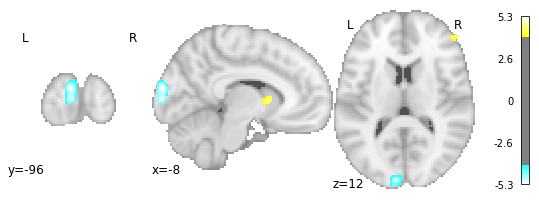

In [44]:
plot_stat_map(z_map, threshold=4, draw_cross=False)

In [39]:
neg_log_pvals_permuted_ols_unmasked = non_parametric_inference(l2_imgs,
                             design_matrix=design_matrix,
                             model_intercept=True, n_perm=5000,
                             two_sided_test=False,
                             smoothing_fwhm=5.0, n_jobs=1)

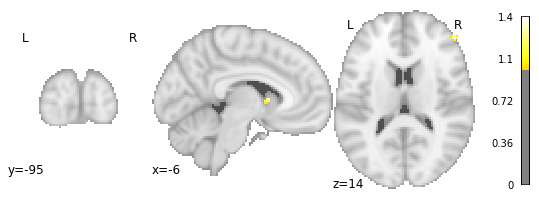

In [43]:
plot_stat_map(
    neg_log_pvals_permuted_ols_unmasked, colorbar=True, 
    threshold=1, draw_cross=False, cut_coords = (-6, -95, 14))
# The neg-log p-values obtained with non parametric testing are capped at 3
# when the number of permutations is 1e3.

### Compared to the randomise output

In [ ]:
plot_stat_map(os.path.join(l3_path, 'rand_tfce_tstat1_pos_overall-mean_reward_par_model3_reg-rt0.nii.gz'), threshold = 4.6, draw_cross=False)

## Are the z values larger in group maps of nilearn example dataset?

No.

In [ ]:
from nilearn.datasets import fetch_localizer_contrasts
n_subjects = 5
data = fetch_localizer_contrasts(["left vs right button press"], n_subjects,
                                 get_tmaps=True)

In [ ]:
for cidx, tmap in enumerate(data['tmaps']):
    plot_glass_brain(tmap, colorbar=True, threshold=2.0,
#                               axes=axes[int(cidx / 4), int(cidx % 4)],
                              plot_abs=False, display_mode='z')

In [ ]:
second_level_input = data['cmaps']
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

In [ ]:
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)

In [ ]:
z_map = second_level_model.compute_contrast(output_type='z_score')


In [ ]:
from scipy.stats import norm
p_val = 0.001
p001_unc = norm.isf(p_val)
display = plot_glass_brain(
    z_map, threshold=p001_unc, colorbar=True, display_mode='z', plot_abs=False,
    title='group left-right button press (unc p<0.001)')